In [1]:
%matplotlib inline
import os
import time
import numpy as np
from matplotlib import pyplot as plt

from caen_felib import lib, device, error

# Get CAEN FELib path
print(f'CAEN FELib found at: {lib.path} (version={lib.version})')

CAEN FELib found at: libCAEN_FELib.so (version=1.3.2)


In [2]:
from lgdo import lh5, Table, Array, WaveformTable, ArrayOfEqualSizedArrays

## Connect

In [ ]:
dig = device.connect("dig2://caendgtz-usb-66154")
print(f'Connected to digitizer (handle={hex(dig.handle)}, name={dig.name})')

In [ ]:
tree = dig.get_device_tree()

In [ ]:
for par, par_dict in tree["par"].items():
#for par, par_dict in tree["ch"]["0"]["par"].items():
    if isinstance(par_dict, dict) and "accessmode" in par_dict:
        if par_dict['accessmode']['value'] == "READ_ONLY":
            print(" ---> ",par,par_dict,"\n")
        else:
            alv = []
            if 'allowedvalues' in par_dict:
                allowedvalues = par_dict['allowedvalues']
                for a in allowedvalues:
                    if isinstance(allowedvalues[a], dict):
                        alv.append(allowedvalues[a]["value"])
            elif "minvalue" in par_dict:
                alv = f"From {par_dict['minvalue']['value']} to {par_dict['maxvalue']['value']}, steps of {par_dict['increment']['value']}"
    
            def_val = ""
            if 'defaultvalue' in par_dict:
                def_val = par_dict['defaultvalue']['value']
            #print(f"    {par}: {def_val} # ({par_dict['datatype']['value']}) [{alv}] {par_dict['description']['value']}")

In [ ]:
# Reset
dig.cmd.Reset()

fw_type = dig.par.fwtype.value
fw_ver = dig.par.fpga_fwver.value
print(fw_type, fw_ver)

adc_samplrate_msps = float(dig.par.adc_samplrate.value)  # in Msps
adc_n_bits = int(dig.par.adc_nbit.value)
sampling_period_ns = int(1e3 / adc_samplrate_msps)

print(f"Sampling rate = {adc_samplrate_msps} MHz, n. bit = {adc_n_bits}, Sampling period = {sampling_period_ns} ns")

# Configuration parameters
nch = int(dig.par.NumCh.value)
active_ch = 2
reclen = 8000 #sample
pretrg = 4000 #sample
dc_offset = 10

dig.par.iolevel.value = "TTL"
dig.par.globaltriggersource.value = "TrgIn"

# Set some channel parameters
for i, ch in enumerate(dig.ch):
    ch.par.chenable.value = "TRUE" if i < active_ch else "FALSE"  # Enable only channel 0
    ch.par.eventtriggersource.value = "GLOBALTRIGGERSOURCE"
    ch.par.wavetriggersource.value = "GLOBALTRIGGERSOURCE"
    ch.par.chrecordlengths.value = f"{reclen}"
    ch.par.chpretriggers.value = f"{pretrg}"
    ch.par.waveanalogprobe0.value = "ADCINPUT"
    ch.par.wavedigitalprobe0.value = "TRIGGER"
    ch.par.wavedigitalprobe1.value = "ADCSaturation"
    ch.par.dcoffset.value = f"{dc_offset}"

## Configure endpoint

In [ ]:
data_format = [
    {
        'name': 'CHANNEL',
        'type': 'U8',
        'dim' : 0
    },
    {
        'name': 'TIMESTAMP',
        'type': 'U64',
        'dim': 0,
    },
    {
        'name': 'ENERGY',
        'type': 'U16',
        'dim': 0,
    },
    {
        'name': 'ANALOG_PROBE_1',
        'type': 'U16',
        'dim': 1,
        'shape': [reclen]
    },
    {
        'name': 'ANALOG_PROBE_1_TYPE',
        'type': 'I32',
        'dim': 0
    },
    {
        'name': 'DIGITAL_PROBE_1',
        'type': 'U8',
        'dim': 1,
        'shape': [reclen]
    },
    {
        'name': 'DIGITAL_PROBE_1_TYPE',
        'type': 'I32',
        'dim': 0
    },
    {
        'name': 'DIGITAL_PROBE_2',
        'type': 'U8',
        'dim': 1,
        'shape': [reclen]
    },
    {
        'name': 'DIGITAL_PROBE_2_TYPE',
        'type': 'I32',
        'dim': 0
    },
    {
        'name': 'WAVEFORM_SIZE',
        'type': 'SIZE_T',
        'dim': 0
    }
]

In [ ]:
decoded_endpoint_path = "dpppha"
endpoint = dig.endpoint[decoded_endpoint_path]
data = endpoint.set_read_data_format(data_format)
dig.endpoint.par.activeendpoint.value = decoded_endpoint_path

channel = data[0].value
ts = data[1].value
energy = data[2].value
analog_probe_1 = data[3].value
analog_probe_1_type = data[4].value  # Integer value described in Supported Endpoints > Probe type meaning
digital_probe_1 = data[5].value
digital_probe_1_type = data[6].value  # Integer value described in Supported Endpoints > Probe type meaning
digital_probe_2 = data[7].value
digital_probe_2_type = data[8].value  # Integer value described in Supported Endpoints > Probe type meaning
waveform_size = data[9].value

In [ ]:
nev = 10
timestamp = np.zeros((active_ch,nev),dtype=np.uint64)
wfs = np.zeros((active_ch,nev,reclen),dtype=np.uint16)
temp_names = ["tempsensfirstadc","tempsenshottestadc","tempsenslastadc","tempsensairin","tempsensairout","tempsenscore","tempsensdcdc"]
temperatures = np.zeros((nev,len(temp_names)),dtype=float)

In [ ]:
for i in dig.par.child_nodes:
    print(f'type: {i.type.name}\tname:{i.name}')
    for j in i.child_nodes:
        print(f'\t{j.type.name}\t{j.name} = {j.value}')

In [ ]:
dig.cmd.armacquisition()
dig.cmd.swstartacquisition()

for i in range(nev*active_ch):
    #dig.cmd.sendswtrigger()
    try:
        endpoint.read_data(-1, data)
        wfs[channel,i//active_ch] = analog_probe_1
        timestamp[channel,i//active_ch] = ts
        for j, temp in enumerate(temp_names):
            temp_value = float(dig.get_value(f"/par/{temp}"))
            temperatures[i//active_ch][j] = temp_value
    except error.Error as ex:
        if ex.code == error.ErrorCode.TIMEOUT:
            continue
        if ex.code == error.ErrorCode.STOP:
            break
        else:
            raise ex
dig.cmd.disarmacquisition()

# Reading files

In [50]:
def decode_low_flag(value):
    flag_mapping = {
        0: "Event waveform occurred during external inhibit",
        1: "Event waveform under-saturation",
        2: "Event waveform oversaturation",
        3: "External trigger",
        4: "Global trigger",
        5: "Software trigger",
        6: "Self trigger",
        7: "LVDS trigger",
        8: "64 channel trigger",
        9: "ITLA trigger",
        10: "ITLB trigger"
    }
    active_flags = ""
    for bit, name in flag_mapping.items():
        if value & (1 << bit):
            active_flags += f"{name}"
    return active_flags
def decode_high_flag(value):
    high_priority_mapping = {
        0: "Pile-Up",
        1: "Pile-up rejector guard event",
        2: "Event Saturation",
        3: "Post saturation event",
        4: "Trapezoid saturation event",
        5: "SCA selected event"
    }
    active_flags = ""
    for bit, name in high_priority_mapping.items():
        if value & (1 << bit):
            active_flags += f"{name}"
    return active_flags

In [76]:
raw_file = ["/home/legendaryno/tmp/dpp_test_th5_trise40_20251223T175642Z.lh5"]

raw_data0 = lh5.read("ch000/raw",raw_file)
raw_data1 = lh5.read("ch001/raw",raw_file)

print(raw_data0.keys())
timestamp0 = raw_data0.timestamp.nda
timestamp1 = raw_data1.timestamp.nda
wfs0 = raw_data0.waveform.values.nda
wfs1 = raw_data1.waveform.values.nda
time_filter0 = raw_data0.time_filter.values.nda
time_filter1 = raw_data1.time_filter.values.nda
flag_low0 = raw_data0.flag_low.nda
flag_low1 = raw_data1.flag_low.nda
print(wfs0.shape)
print(wfs1.shape)
dts0 = np.linspace(0,len(wfs0[0])*8/1000,len(wfs0[0]))
dts1 = np.linspace(0,len(wfs1[0])*8/1000,len(wfs1[0]))

dict_keys(['digital_1', 'digital_2', 'digital_3', 'digital_4', 'energy', 'eventnumber', 'flag_high', 'flag_low', 'time_filter', 'timestamp', 'waveform'])
(105, 4000)
(174, 4000)


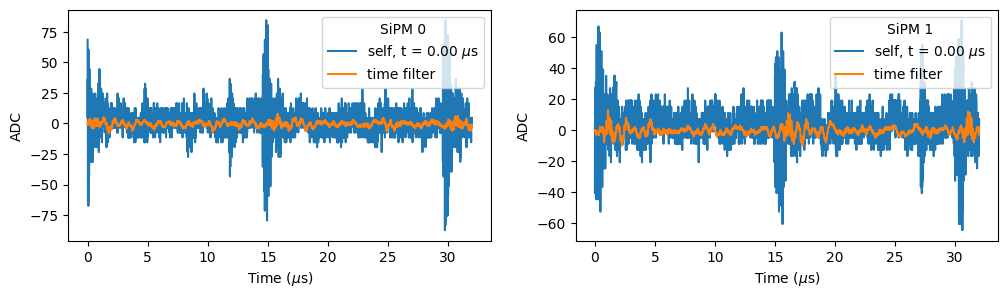

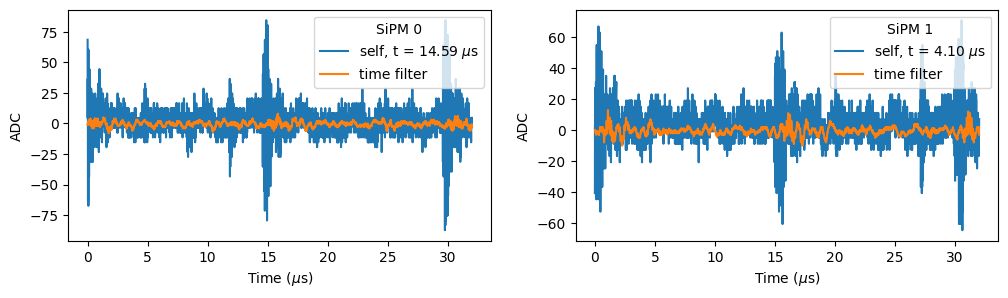

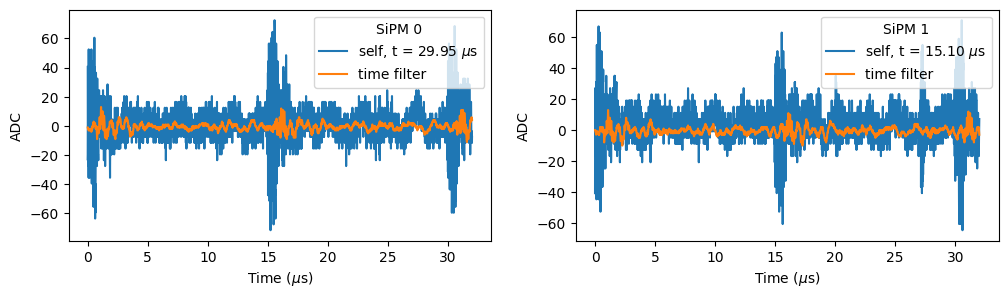

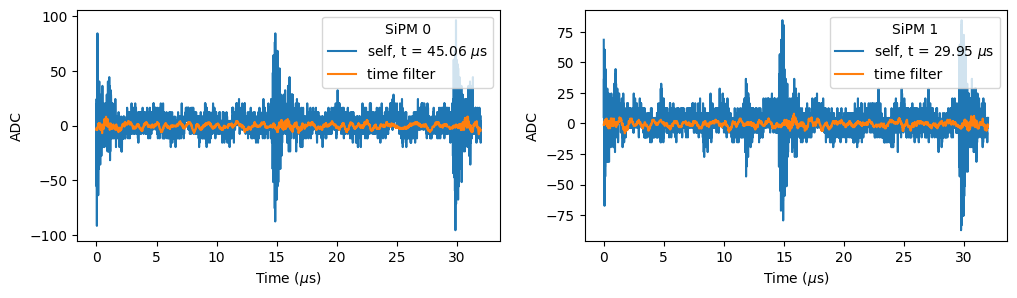

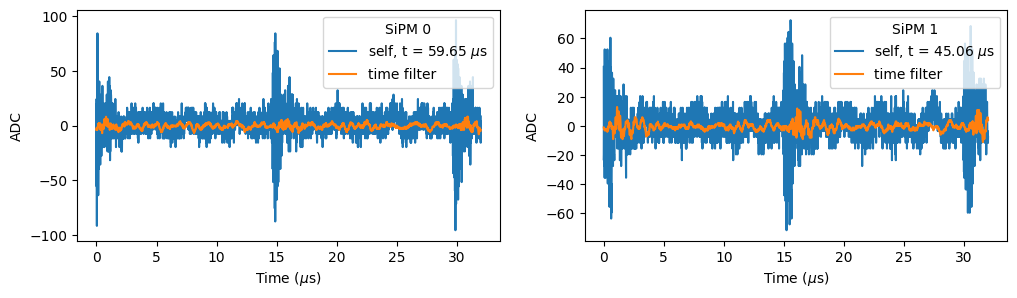

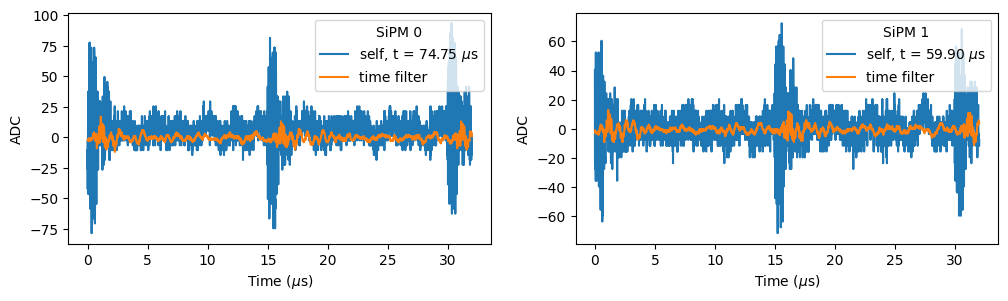

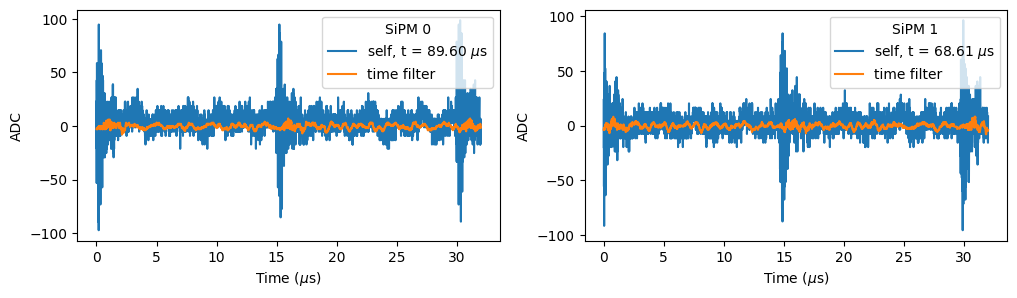

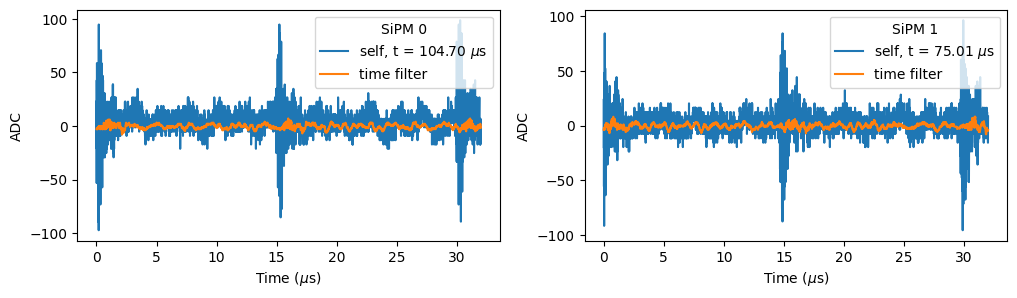

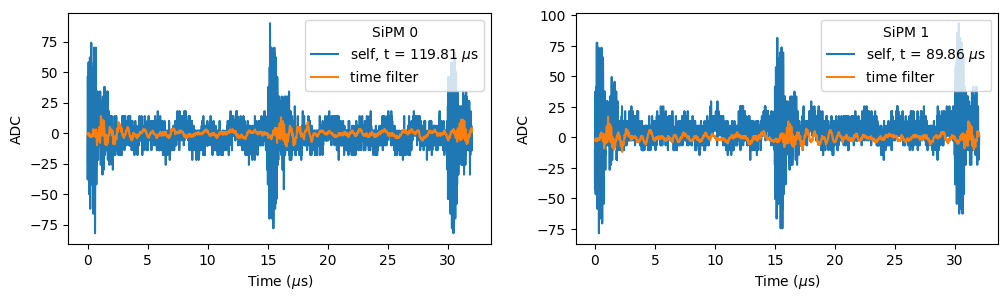

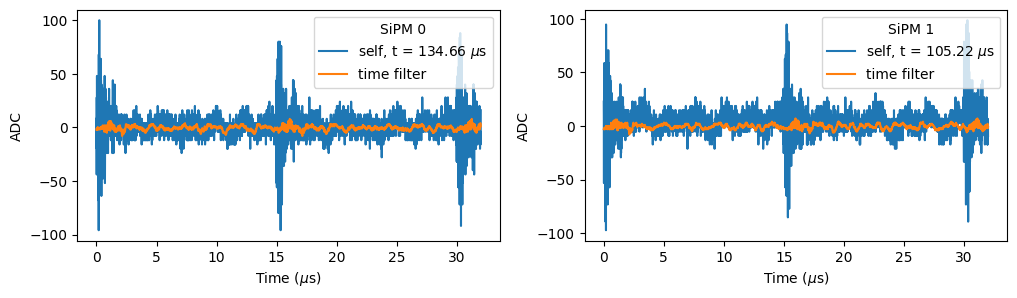

In [77]:
wfs0_bl, wfs1_bl = np.zeros_like(wfs0,dtype=float), np.zeros_like(wfs1,dtype=float)
for i in range(10):#len(wfs0_bl)):
    ts0 = (timestamp0[i] - timestamp0[0]) / 1e3
    ts1 = (timestamp1[i] - timestamp1[0]) / 1e3
    fig, ax = plt.subplots(1,2,figsize=(12,3))
    if "Self" in decode_low_flag(flag_low0[i]): flag0 = "self"
    else: flag0 = "glob"
    if "Self" in decode_low_flag(flag_low1[i]): flag1 = "self"
    else: flag1 = "glob"
    wfs0_bl[i] = wfs0[i] - np.mean(wfs0[i,:100])
    wfs1_bl[i] = wfs1[i] - np.mean(wfs1[i,:100])
    
    ax[0].plot(dts0,wfs0_bl[i],label=fr"{flag0}, t = {ts0:.2f} $\mu$s")
    ax[0].plot(dts0,time_filter0[i],label="time filter")
    ax[1].plot(dts1,wfs1_bl[i],label=fr"{flag1}, t = {ts1:.2f} $\mu$s")
    ax[1].plot(dts1,time_filter1[i],label="time filter")
    #ax.set_xlim(3.5,5)
    #ax[0].set_ylim(-100,500)
    ax[0].legend(title="SiPM 0",loc="upper right")
    ax[1].legend(title="SiPM 1",loc="upper right")
    ax[0].set_xlabel(r"Time ($\mu$s)")
    ax[1].set_xlabel(r"Time ($\mu$s)")
    ax[0].set_ylabel("ADC")
    ax[1].set_ylabel("ADC")